In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA INITIZLIZATION**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
if 'train.tsv' not in os.listdir(): 
    !kaggle competitions download -c mercari-price-suggestion-challenge
    get_ipython().system_raw("7z x \*.7z && rm *.7z")
    get_ipython().system_raw("7z x \*.zip && rm *.zip")

  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 63.9MB/s]
 96% 283M/294M [00:01<00:00, 155MB/s]
100% 294M/294M [00:01<00:00, 157MB/s]
 74% 25.0M/34.0M [00:00<00:00, 24.1MB/s]
100% 34.0M/34.0M [00:00<00:00, 46.5MB/s]
100% 7.77M/7.77M [00:00<00:00, 80.1MB/s]

 82% 61.0M/74.3M [00:00<00:00, 71.3MB/s]
100% 74.3M/74.3M [00:00<00:00, 117MB/s] 


In [ ]:
import pandas as pd

train_df = pd.read_csv('train.tsv', sep='\t')

# Price range should be $5-$2000, https://www.mercari.com/us/help_center/article/69
train_df = train_df[train_df['price']>=5]  # Removing the prodicts with prices less than 5
train_df = train_df[train_df['price']<=2000]  # Removing the prodicts with prices more than 2000
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


**Adding log price column**

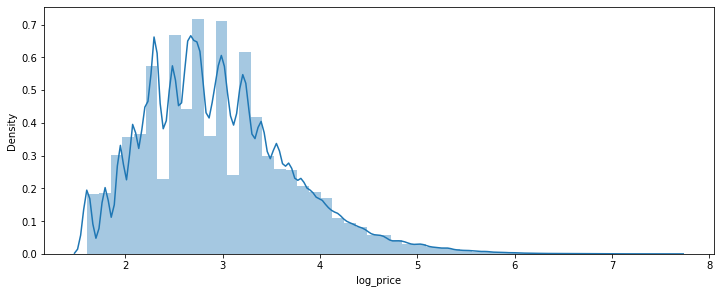

In [ ]:
from scipy import stats

train_df['log_price'] = np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_price'])

**Train Test Split**

In [ ]:
X = train_df.drop(['train_id','log_price','price'], axis=1)
y = train_df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
del X, y, train_df

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1157452, 6)
(1157452,)
(289364, 6)
(289364,)


# **ENSEMBLE**

## **Feature Engineering for MLP**

### **Filling missing values**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

### **Text Pre-processing**

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stem_sentence(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    root = []
    for w in words: 
        root.append(ps.stem(w))
    return " ".join(root)

def preprocess_descriptive_text_column(sentance):
    """
    Description:
    This function will process the text data.
    This function will perform decontracting words, removing stop words, removing special characters and then apply stemming on the words in the sentence.

    Input: original sentence
    Output: processed sentence
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    sent = decontract_text(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)

    root_sent = stem_sentence(sent.lower().strip())
    return root_sent

### **Fill Missing Brand Names**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brands_list.pkl', 'rb') as f:
    existing_brands = pickle.load(f)
    
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brand_names_categories_dict.pkl', 'rb') as f:
    brand_names_categories = pickle.load(f)

In [ ]:
def brand_guesser(row):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want our guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe row with missing brand names
    Output: dataframe row with filled brand names
    """
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    brand, name, cn = row
    brand = brand.lower()
    if brand=='unk_brand':
        for brand in existing_brands:
            if brand in name.lower() and cn in brand_names_categories[brand]:
                return brand
            
    return brand

### **Split Categories**

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separates the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then it will remove the original category_name field.

    Input: Dataframe having category_name field
    Output: Dataframe with splitted categories
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

### **Adding Item Description len and Item Name len**

In [ ]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

### **Add is_expensive**

In [ ]:
def get_is_expensive_feature(df):
    """
    Description:
    This funciton will generate a feature which will tell if the brand is expensive or not.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'rb') as f:
        expensive_brands = pickle.load(f)
    
    is_expensive_binary = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    is_expensive_binary = scipy.sparse.csr_matrix(is_expensive_binary.values)
    is_expensive_binary = is_expensive_binary.reshape(-1,1) # Now the shape will be (1111901, 1)
    return is_expensive_binary

### **Make Shipping data sparse**

In [ ]:
def get_shipping_feature(df):
    """
    Description:
    This funciton will just get the shipping data in sparse form.

    Input: Dataframe
    Output: Sparse shipping data
    """
    sparse_shipping = scipy.sparse.csr_matrix(df['shipping'].values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

### **Vectorizing data**

In [ ]:
def vectorize_data(col_data, vectorizer=None):
    """
    Description:
    This funciton will vectorize the input column data.

    Input: dataframe column
    Output: one-hot encoded values and the fitted vectorizer
    """
    if vectorizer==None:
        vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
        vectorizer.fit(col_data)
    ohe_data = vectorizer.transform(col_data)
    return ohe_data, vectorizer

### **Feature Engineering pipeline**

In [ ]:
def feature_pipeline(X_data, general_cat_vectorizer=None, subcat_1_vectorizer=None, subcat_2_vectorizer=None, brand_name_vectorizer=None, item_name_vectorizer=None, 
                     item_desc_vectorizer=None, scaler_name_len=None, scaler_desc_len=None):
    """
    Description: This function will do all the feature engineering on the input X_data,
                and create a final data, ready for training.

    Input: Original input dataframe, 
                    the fitted vectorizers for all categorical and text columns [optional: used during inference],
                    scalers [optional: used during inference]
    Output: Featurized data
    """
    print()
    print("Filling missing values...")
    X_data = fill_missing_values(X_data)

    #X_data['item_description'] = preprocess_descriptive_text_column(X_data['item_description'].values)
    #X_data['name'] = preprocess_descriptive_text_column(X_data['name'].values)
    #X_data['item_description'] = X_data['item_description'].apply(lambda x: str(x).lower()) ### temp step ###
    #X_data['name'] = X_data['name'].apply(lambda x: str(x).lower())                         ### temp step ###
    print("pre-processing text data...")
    X_data['item_description'] = X_data['item_description'].progress_apply(preprocess_descriptive_text_column) ### temp step ###
    X_data['name'] = X_data['name'].progress_apply(preprocess_descriptive_text_column)                         ### temp step ###
    X_data['brand_name'] = X_data['brand_name'].progress_apply(lambda x: str(x).lower())

    print("Guessing the missing brands...")
    X_data['brand_name'] = X_data[['brand_name','name', 'category_name']].progress_apply(brand_guesser, axis = 1)

    print("Splitting categories...")
    X_data = split_categories(X_data)

    print('Getting word lengths')
    name_len, scaler_name_len =  get_len_feature(X_data['name'], scaler_name_len)
    desc_len, scaler_desc_len =  get_len_feature(X_data['item_description'], scaler_desc_len)

    print("Getting is_expensive brand feature...")
    sparse_is_expensive = get_is_expensive_feature(X_data)

    print("Getting sparse shipping data...")
    sparse_shipping = get_shipping_feature(X_data)

    print("OHE vectorizing the text and categorical variables...")
    general_cat_ohe, general_cat_vectorizer = vectorize_data(X_data['general_cat'].values.astype('U'), general_cat_vectorizer)
    print("general cat done...")
    subcat_1_ohe, subcat_1_vectorizer = vectorize_data(X_data['subcat_1'].values.astype('U'), subcat_1_vectorizer)
    print("sub cat 1 done...")
    subcat_2_ohe, subcat_2_vectorizer = vectorize_data(X_data['subcat_2'].values.astype('U'), subcat_2_vectorizer)
    print("sub cat 2 done...")
    brand_name_ohe, brand_name_vectorizer = vectorize_data(X_data['brand_name'].values.astype('U'), brand_name_vectorizer)
    print("brand name done...")
    item_name_ohe, item_name_vectorizer = vectorize_data(X_data['name'], item_name_vectorizer)
    print("item name done...")
    item_desc_ohe, item_desc_vectorizer = vectorize_data(X_data['item_description'], item_desc_vectorizer)
    print("item description done...")

    print("Creating the final featurized dataset...")
    X_featurized = hstack((general_cat_ohe, subcat_1_ohe, subcat_2_ohe, brand_name_ohe, item_name_ohe, item_desc_ohe, 
                            desc_len, name_len, X_data['item_condition_id'].values.reshape(-1,1), sparse_shipping)).tocsr()

    print("Done!!!\n---------------------------\n")
    return X_featurized, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len


In [ ]:
X_tr, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len = feature_pipeline(X_train)
#X_te, _, _, _, _, _, _, _, _ = feature_pipeline(X_test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...
general cat done...
sub cat 1 done...
sub cat 2 done...
brand name done...
item name done...
item description done...
Creating the final featurized dataset...
Done!!!
---------------------------



## **Get Input for Simple MLP**

In [ ]:
test = pd.read_csv('test_stg2.tsv', sep='\t')

In [ ]:
X_te_mlp, _, _, _, _, _, _, _, _ = feature_pipeline(test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...
general cat done...
sub cat 1 done...
sub cat 2 done...
brand name done...
item name done...
item description done...
Creating the final featurized dataset...
Done!!!
---------------------------



## **Feature Engineering for CNNs**

### **Filling missing values**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

### **Text Pre-processing**

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_descriptive_text_column(sentance):
    """
    Description:
    This function will process the text data.
    This function will perform decontracting words, removing stop words, removing special characters and then apply stemming on the words in the sentence.

    Input: original sentence
    Output: processed sentence
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    sent = decontract_text(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    sent = sent.lower()
    return sent

### **Fill Missing Brand Names**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brands_list.pkl', 'rb') as f:
    existing_brands = pickle.load(f)
    
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brand_names_categories_dict.pkl', 'rb') as f:
    brand_names_categories = pickle.load(f)

In [ ]:
def brand_guesser(row):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want our guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe row with missing brand names
    Output: dataframe row with filled brand names
    """
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    brand, name, cn = row
    brand = brand.lower()
    if brand=='unk_brand':
        for brand in existing_brands:
            if brand in name.lower() and cn in brand_names_categories[brand]:
                return brand
            
    return brand

### **Split Categories**

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separates the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then it will remove the original category_name field.

    Input: Dataframe having category_name field
    Output: Dataframe with splitted categories
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

### **Adding Item Description len and Item Name len**

In [ ]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

### **Add is_expensive**

In [ ]:
def get_is_expensive_feature(df):
    """
    Description:
    This funciton will generate a feature which will tell if the brand is expensive or not.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'rb') as f:
        expensive_brands = pickle.load(f)
    
    df['is_expensive'] = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    return df

### **Feature Engineering pipeline**

In [ ]:
def feature_pipeline(X_data, scaler_name_len=None, scaler_desc_len=None):
    """
    Description: This function will do all the feature engineering on the input X_data,
                and create a final data, ready for training.

    Input: Original input dataframe, 
                    scalers [optional: used during inference]
    Output: Featurized data
    """
    print()
    print("Filling missing values...")
    X_data = fill_missing_values(X_data)
    
    print("pre-processing text data...")
    X_data['item_description'] = X_data['item_description'].progress_apply(preprocess_descriptive_text_column) ### temp step ###
    X_data['name'] = X_data['name'].progress_apply(preprocess_descriptive_text_column)                         ### temp step ###
    X_data['brand_name'] = X_data['brand_name'].progress_apply(lambda x: str(x).lower())

    print("Guessing the missing brands...")
    X_data['brand_name'] = X_data[['brand_name','name', 'category_name']].progress_apply(brand_guesser, axis = 1)

    print("Splitting categories...")
    X_data = split_categories(X_data)

    print('Getting word lengths')
    X_data['name_len'], scaler_name_len =  get_len_feature(X_data['name'], scaler_name_len)
    X_data['desc_len'], scaler_desc_len =  get_len_feature(X_data['item_description'], scaler_desc_len)

    print("Getting is_expensive brand feature...")
    X_data = get_is_expensive_feature(X_data)

    print("Done!!!\n---------------------------\n")
    return X_data, scaler_name_len, scaler_desc_len

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/BERT CNN/scalers.pkl', 'rb') as f:
    scaler_name_len, scaler_desc_len = pickle.load(f)

In [ ]:
X_te_ft_cnn, _, _ = feature_pipeline(test, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Done!!!
---------------------------



## **Get Input for CNNs**

In [ ]:
# THIS CODE IS USED TO OVERCOME THE UNKNOWN CATEGORICAL VALUES ENCOUNTERED IN THE TEST DATA, WHEN USING Sklearn's LabelEncoder
# We basically add a 'Unknown' category when fitting, to accomodate all the unseen/unknown values in test data
# https://stackoverflow.com/a/56876351/7697658

from sklearn.preprocessing import LabelEncoder
import numpy as np

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
# Why you should not use One Hot Encoding for this,
# https://stackoverflow.com/a/51184399/7697658

# Embedding categorical data,
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
def categorical_embeddings(cat_train, cat_test):
    """
    This function will do Label encoding of the categorical feature.
    """
    vocab_size = len(cat_train.unique())+1
    le = LabelEncoderExt()
    le.fit(cat_train.values)
    encoded_train = le.transform(cat_train.values)
    encoded_test = le.transform(cat_test.values)

    return vocab_size, encoded_train, encoded_test

#vocab_size, encoded_train, encoded_test = categorical_embeddings(X_train['project_subject_subcategories'], X_test['project_subject_subcategories'])

In [ ]:
# How does embedding layer work,
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

def text_embeddings(text_train, text_test):
    """
    This function does the tokenizing, padding, creating vocab and creating the embedding matrix for text data
    """
    # Word Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_train)
    encoded_docs_train = tokenizer.texts_to_sequences(text_train)

    encoded_docs_test = tokenizer.texts_to_sequences(text_test)

    # Getting the 'max len' of doc among the text_train
    len_docs = []
    for doc in text_train:
        splitted_doc = doc.split()
        len_docs.append(len(splitted_doc))
    max_len_doc = max(len_docs)
    #print('max doc len=',max_len_doc) # in terms of words

    text_train_padded = pad_sequences(encoded_docs_train, maxlen=max_len_doc, padding='post')
    text_test_padded = pad_sequences(encoded_docs_test, maxlen=max_len_doc, padding='post')

    vocab_size = len(tokenizer.word_index) + 1
    #print(vocab_size)

    embeddings_index = dict()
    with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/FAST TEXT CNN/wiki-news-300d-1M.vec') as f:
        for line in f:
            w_coef = line.rstrip().rsplit(' ')
            word = w_coef[0]
            coefs = asarray(w_coef[1:], dtype='float32')
            embeddings_index[word]=coefs

    embedding_matrix = zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix, vocab_size, max_len_doc, text_train_padded, text_test_padded

In [ ]:
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/CNN_X_train.csv')
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/CNN_X_test.csv')

In [ ]:
####################### Text data ######################
_, _, _, _, desc_text_test_padded = text_embeddings(X_train['item_description'].apply(str), X_te_ft_cnn['item_description'].apply(str))
_, _, _, _, name_text_test_padded = text_embeddings(X_train['name'].apply(str), X_te_ft_cnn['name'].apply(str))
########################################################


################### Categorical data ###################
_, _, bn_encoded_test = categorical_embeddings(X_train['brand_name'], X_te_ft_cnn['brand_name'])
_, _, gc_encoded_test = categorical_embeddings(X_train['general_cat'], X_te_ft_cnn['general_cat'])
_, _, sc1_encoded_test = categorical_embeddings(X_train['subcat_1'], X_te_ft_cnn['subcat_1'])
_, _, sc2_encoded_test = categorical_embeddings(X_train['subcat_2'], X_te_ft_cnn['subcat_2'])
#########################################################


################### Numeric data ###################
numeric_test_input = pd.concat((X_te_ft_cnn['desc_len'], X_te_ft_cnn['name_len']), axis=1).to_numpy()


X_te_cnn_inputs = [desc_text_test_padded, name_text_test_padded, bn_encoded_test, gc_encoded_test, sc1_encoded_test, sc2_encoded_test, tf.one_hot(X_te_ft_cnn['item_condition_id'], 5),\
                tf.one_hot(X_te_ft_cnn['shipping'], 2), tf.one_hot(X_te_ft_cnn['is_expensive'], 2), numeric_test_input]

# **SUBMISSION**

In [ ]:
mlp_model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/DL_Ensmeble/Model Checkpoints/Model_MLP_Checkpoints/BEST_MODEL.hdfs"
mlp_model_best = tf.keras.models.load_model(mlp_model_path)

In [ ]:
cnn_model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/DL_Ensmeble/Model Checkpoints/Model_CNN_Checkpoints/BEST_CNN_MODEL.hdfs"
cnn_model_best = tf.keras.models.load_model(cnn_model_path)

In [ ]:
ft_cnn_model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/DL_Ensmeble/Model Checkpoints/FAST TEXT CNN/BEST_FT_CNN_MODEL.hdfs"
ft_cnn_model_best = tf.keras.models.load_model(ft_cnn_model_path)

In [ ]:
mlp_pred = mlp_model_best.predict(X_te_mlp)
cnn_pred = cnn_model_best.predict(X_te_cnn_inputs)
ft_cnn_pred = ft_cnn_model_best.predict(X_te_cnn_inputs)

mlp_pred = np.exp(mlp_pred)
cnn_pred = np.exp(cnn_pred)
ft_cnn_pred = np.exp(ft_cnn_pred)

In [ ]:
ensemble_pred = (mlp_pred*0.5 + ft_cnn_pred*0.3 + cnn_pred*0.2)

ensemble_pred = np.squeeze(ensemble_pred, axis=1)
my_submission = pd.DataFrame({'test_id': test['test_id'], 'price': ensemble_pred})
my_submission.to_csv("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Submission/submission_dl_ensemble.csv", index=False)

# **Kaggle Submission Score**

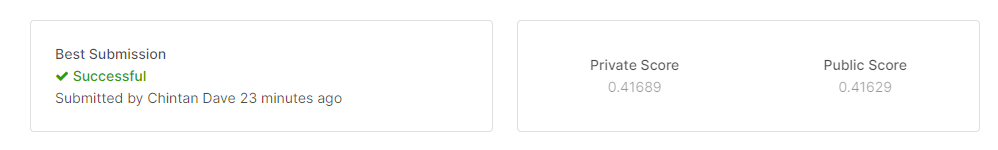

**65th Position on private leaderboard**

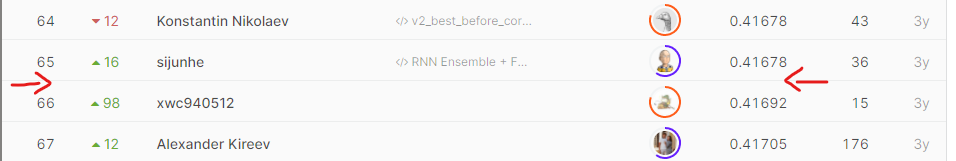